In [ ]:
# default_exp embeddings
# hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

# DeepWalk with Backwards Connection

In this notebook, we will test the DeepWalk algorithm on some simple directed graph and investigate its embedding. Then, we will add backwards connection to the original DeepWalk algorithm from [this paper](https://arxiv.org/pdf/1403.6652.pdf) and try to apply the algorithm to directed graph to see if it improves the embedding.

We will generate our data using the Directed Stochastic Block Model.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from directed_graphs.datasets import DirectedStochasticBlockModel
from sklearn.decomposition import PCA
from torch_geometric.utils import to_networkx
from karateclub import DeepWalk

## 2 clusters: 1 source and 1 sink

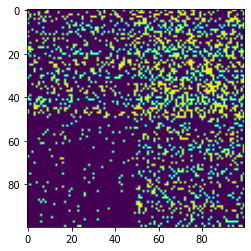

In [ ]:
aij = np.array([[0.4,0.4],[0.4,0.4]])
bij = np.array([[0.5,0.9],[0.1,0.5]])
dataset = DirectedStochasticBlockModel(num_nodes=100, num_clusters=2, aij = aij, bij = bij)
data = dataset[0] # there is only graph in this dataset
sparse_A = torch.sparse_coo_tensor(data.edge_index,torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
plt.imshow(A)

In [ ]:
# the dataset must be converted to networkx format for node2vec
G_nx = to_networkx(data, to_undirected=False)

# train model and generate embedding
model = DeepWalk(walk_length=100, dimensions=64, window_size=5)
model.fit(G_nx)
embedding = model.get_embedding()
# print Embedding shape
print(embedding.shape)

(100, 64)


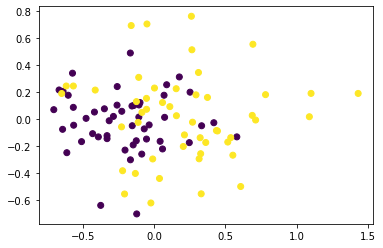

In [ ]:
# plot nodes graph
clusters = np.repeat([0,1],50)
pca = PCA(n_components=2)
pca_out= pca.fit_transform(embedding)
sc = plt.scatter(pca_out[:, 0], pca_out[:, 1], c=clusters)
plt.show()
  

DeepWalk seems to be able to learn quite good embeddings for this simple directed graph. Let try combining the code above into one nice function.

In [ ]:
# export
import numpy as np
import matplotlib.pyplot as plt
from karateclub import DeepWalk
from sklearn.decomposition import PCA
from torch_geometric.utils import to_networkx

def deepwalk_and_pca_plot(data,n_clusters,title="",to_undirected=False):
  G_nx = to_networkx(data, to_undirected=to_undirected)
  n_points = data.x.shape[1]
  # Embed nodes
  model = DeepWalk(walk_length=10, dimensions=64, window_size=5)
  model.fit(G_nx)
  embedding = model.get_embedding()
  # Define clusters
  clusters = np.repeat(list(range(n_clusters)),n_points/n_clusters)
  # Visualize
  print("performing PCA...")
  pca = PCA(n_components=2)
  clusters = np.repeat(list(range(n_clusters)),n_points/n_clusters)
  pcs = pca.fit_transform(embedding)
  plt.figure()
  scatter = plt.scatter(pcs[:,0],pcs[:,1],c=clusters)
  plt.legend(handles = scatter.legend_elements()[0], title="Blobs", labels=list(range(n_clusters)))
  plt.suptitle(title)
  return embedding

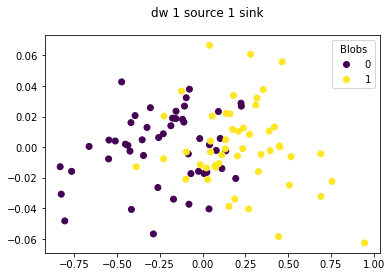

In [ ]:
embedding = deepwalk_and_pca_plot(data, 2, "dw 1 source 1 sink")

## Symmetrize the directed graph.

We try to perform deepwalk on the symmetrical version of the previous directed graph. We would expect no distinction between the 2 cluster.

performing PCA...


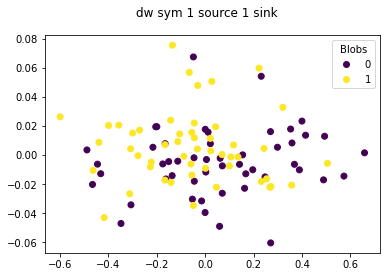

In [ ]:
embedding = deepwalk_and_pca_plot(data, n_clusters=2, title="dw sym 1 source 1 sink", to_undirected=True)

## Bipartite graph

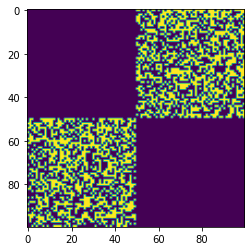

In [ ]:
from directed_graphs.datasets import DirectedStochasticBlockModel
aij = np.array([[0.0,1],[1,0]])
bij = np.array([[0.5,0.5],[0.5,0.5]])
dataset = DirectedStochasticBlockModel(num_nodes=100, num_clusters=2, aij = aij, bij = bij)
data = dataset[0] # there is only graph in this dataset
sparse_A = torch.sparse_coo_tensor(data.edge_index,torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
plt.imshow(A)

performing PCA...


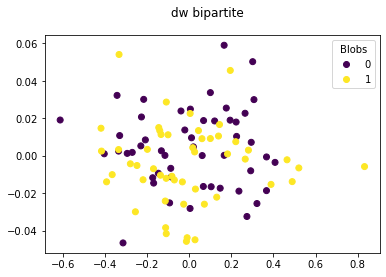

In [ ]:
embedding = deepwalk_and_pca_plot(data, n_clusters=2, title="dw bipartite")